<a href="https://colab.research.google.com/github/RafaelPintroSchmitt/synthetic_descent/blob/main/synth_softmax.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim

#Read the data
data = pd.read_csv('/content/cigprocessed2.csv')
#Generate pretreatment data
ylow = 1989
yhigh = 2000
pretreat_actual = data.filter(regex='^(?!cigsale(' + '|'.join([str(i) for i in range(ylow, yhigh+1)]) + ')).*$', axis=1)
pretreat_actual = pretreat_actual.drop(columns=['state'])
pretreat_actual = torch.tensor(pretreat_actual.values, dtype=torch.float)
pretreat_actual = pretreat_actual.t()

#Read the data
data = pd.read_csv('/content/cigprocessed2.csv')
#Generate datatrain, excluding columns cigsale1989-2000 (using wildcards)
ylow = 1989
datatrain = data.filter(regex='^(?!cigsale(' + '|'.join([str(i) for i in range(ylow, yhigh+1)]) + ')).*$', axis=1)

#Generate datapredict, including columns cigsale1989-2000 (using wildcards) and state
ylow = 1989
datapredict = data.filter(regex='^(cigsale(' + '|'.join([str(i) for i in range(ylow, yhigh+1)]) + ')|state)$', axis=1)

#drop state column from datatrain, datapredict, calitrain, and calipredict
datatrain = datatrain.drop(columns=['state'])
datapredict = datapredict.drop(columns=['state'])

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [3]:
#convert the dataframes to tensors or vectors
datatrain = torch.tensor(datatrain.values, dtype=torch.float)
datapredict = torch.tensor(datapredict.values, dtype=torch.float)

datatrain = datatrain.t()

#now to the same but constraining A values to be between 0 and 1
#initialize A
A = torch.randn(datatrain.shape[1], datatrain.shape[1], requires_grad=True)
#get a mask that is False for the diagonal and True for the rest
mask = torch.eye(datatrain.shape[1]) == 0

#initialize the optimizer
optimizer = optim.Adam([A], lr=0.05)

#initialize the loss function
loss_fn = nn.MSELoss()

#define softmax function
def softmax(x):
    return torch.exp(x) / torch.sum(torch.exp(x), dim=0)

In [ ]:
datatrain.to(device)
A.to(device)

#train the model
for epoch in range(3000):
    optimizer.zero_grad()
    loss = loss_fn(torch.mm(datatrain, softmax(torch.abs(A)*mask)), datatrain)
    loss.backward()
    optimizer.step()
    print('Epoch:', epoch, 'Loss:', loss.item())

In [5]:
A = softmax(torch.abs(A)*mask)
torch.round(A*100)/100

tensor([[0.0000, 0.2200, 0.0000,  ..., 0.1900, 0.0000, 0.0000],
        [0.4800, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.1700, 0.0000, 0.0000],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],
       grad_fn=<DivBackward0>)

In [6]:
print(torch.sum(A, dim=0))

tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000], grad_fn=<SumBackward1>)


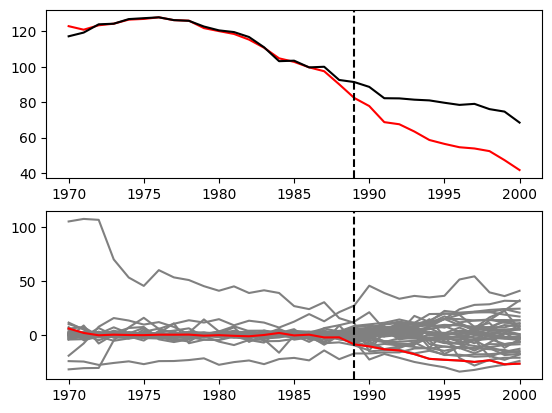

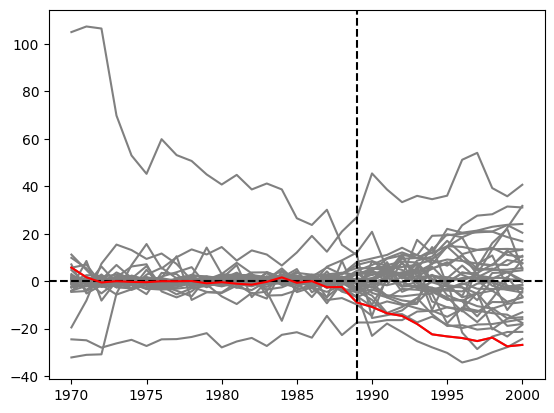

In [7]:
pretreat = torch.mm(pretreat_actual, A)
#get a pandas dataframe with the values of pretreat.t()
pretreat = pd.DataFrame(pretreat.detach().numpy())
#same for datatrain
pretreat_actual = pd.DataFrame(pretreat_actual.detach().numpy())

#post treat
posttreat = torch.mm(datapredict.t(), A)
#get a pandas dataframe with the values of posttreat.t()
posttreat = pd.DataFrame(posttreat.detach().numpy())
#same for datapredict
posttreat_actual = pd.DataFrame(datapredict.t().detach().numpy())

#concatenate pretreat and posttreat, making sure the indexing is summed (not repeated)
synthetic = pd.concat([pretreat, posttreat], axis=0)
#restablish the index
synthetic.index = range(len(synthetic))
#add years from 1970 to 2000 as a column
synthetic["year"] = range(1970, 2001)

#concatenate datatrain and datapredict, making sure the indexing is summed (not repeated)
actual = pd.concat([pretreat_actual, posttreat_actual], axis=0)
#restablish the index
actual.index = range(len(actual))
#add years from 1970 to 2000 as a column
actual["year"] = range(1970, 2001)

#subtract the synthetic control from the actual data using synthetic and actual
calipredict = actual.drop(columns=['year']) - synthetic.drop(columns=['year'])
#add year column
calipredict["year"] = range(1970, 2001)

#merge the 2 figures levels and diff in a single panel
fig, axs = plt.subplots(2)
axs[0].plot(actual['year'], actual.iloc[:, 2], color='red')
axs[0].plot(synthetic['year'], synthetic.iloc[:, 2], color='black')
axs[0].axvline(x=1989, color='black', linestyle='--')
axs[1].plot(calipredict['year'], calipredict.drop(columns='year'), color='grey')
axs[1].plot(calipredict['year'], calipredict.iloc[:, 2], color='red')
axs[1].axvline(x=1989, color='black', linestyle='--')

#now just the differences in a single panel
fig, axs = plt.subplots(1)
axs.plot(calipredict['year'], calipredict.drop(columns='year'), color='grey')
axs.axhline(y=0, color='black', linestyle='--')
axs.plot(calipredict['year'], calipredict.iloc[:, 2], color='red')
axs.axvline(x=1989, color='black', linestyle='--')
